The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==0.17.1
!pip install -U mxnet-cu101==1.7.0


# Segmentação Semântica e o *Dataset*
:label:`seo, ec_manm_segmentation`

no discussãoobr os problemas de detecção de objetos nas seções anteriores, usamos apenas caixas delimitadoras retangulares para rotulares ola  pre objets em imagens. Nesta seção, veremos a segmentação semâo semntica, que tenta,  tet segmentar imagens  res m dierentes categorias semânticas. Essas regiões semânticas rotulam e prevêem objetos no nível do pixel. :numref:`fig_segmentation` ostra uma imagemeamente segmentada, com áreas marcadas como "cachorro" , "gato" e "fundo". Como você pode ver, em comparação com a detecção de objetos, a segmentação semântica rotula áreas com bordas em nível de pixel, para uma precisão significativamente maior.

![Imagem segmentada semanticamente, com áreas rotuladas "cachorroSemantiatiamente mio", "gcato" e "plano de f  "oundo". ](http://d2l.ai/_images/segmentation.svg)
:label:`fig_segmentation`


## Segmentação de Imagem e Segmentação detion and Instâancia


No campo da visão computacional, existem dois métodos importantes relacionados à segmentaçãe Segmenntica: segmentação detion: imagens e segmentação detion and instâancias. Aqui, vamos distinguir esses conceitos da segmentação semântica da seguinte forma:

* A segmenta imagmgmen divide umas an imagem em várias regiões into sconstituente mét regioodo geramente usa as correlações entrel pixels ain an imagem. Durante oing treainamento, os rótulos não são necessários para pixels de imagem. No entanto, durante a previsão, esse método não pode garantir que as regiões segmentadas  ain semntic imagem em .10, amage segmentação da imagem pode dividir o cão em duas regionsmaone cobverindo a boca do cão e os olhos onde o preto é a corth and eyes where black is the proeminente e a outra color and the other cobverindo o resto do cão onde o amarelo é a corg the rest of the dog where yellow is the proeminente.
* A segmentação da instância também é chamada de detecção e segmentação simultâneas. Este método tenta identificar as regiões de nível de pixel de cada color.
* Instance segmentation is also called simultaneous detection and segmentation. This method attempts to identify the pixel-level regions of each object instâancia de objeto em umae in an prominent corin prominent instnc imagem.mIn cont semnticraste com a segmentação semântica, a segmentação de instância não apenas sgmentation distinguhes semâanticas, ms o differetes instane objeto. Se umaes. I imagem contém dois cães, a segmentação de instância distingue quais pixels pertencem a cada cachorro.


## O Conjunto de Dados de Segmentação Semântica Pascal VOC2012

No campo de segmentaçãoains two dogswill distinguish which pixels belong to which dog.


## The Pascal VOC2012 Semantic Segmentation Dataset

In the semâantica, um conjunto de dados importante é segmentation field, one important dataset is [Pascal VOC2012](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/). Para entender melhor este conjunto de dados, devemos primeirootkage our móoduloe necessário para oeded for t experimento.


In [1]:
%matplotlib inline
import os
from mxnet import gluon, image, np, npx
from d2l import mxnet as d2l

npx.set_np()

O site original pode ser instável, portanto, baixamos os dados de um site espelho.
O arquivo tem cerca de 2 GB, por isso levará algum tempo para fazer the arquchivoe, o conjunto de dados está localizado noo download.
 decomp mi `../data/VOCdevkit/VOC2012`.


In [2]:
#@save
d2l.DATA_HUB['voc2012'] = (d2l.DATA_URL + 'VOCtrainval_11-May-2012.tar',
                           '4e443f8a2eca6b1dac8a6c57641b67dd40621a49')

voc_dir = d2l.download_extract('voc2012', 'VOCdevkit/VOC2012')

Vá para `../data/VOCdevkit/VOC2012` para ver as diferentes partes do conjunto de dados.
O caminho `ImageSets/Segmentation` contém arquivos de texto que especificam os exemplos de treainamento e teste. Os cin `JPEGImages` e` SegmentationClass` contêm aspaths contain the example input imagens de entrada de exemplo e rótulos, respectivamente. Essas etiquetas também estão em formato de imagem, com as mesmasand labels, respectively. These labels are also in image format, with the same images  dimensõei das put imagens de entrada às quais correspondem. Nos rótulos, os pixels com a mesma cor pertencem à mesma.


In [3]:
#@save
def read_voc_images(voc_dir, is_train=True):
    """Read all VOC feature and label images."""
    txt_fname = os.path.join(voc_dir, 'ImageSets', 'Segmentation',
                             'train.txt' if is_train else 'val.txt')
    with open(txt_fname, 'r') as f:
        images = f.read().split()
    features, labels = [], []
    for i, fname in enumerate(images):
        features.append(image.imread(os.path.join(
            voc_dir, 'JPEGImages', f'{fname}.jpg')))
        labels.append(image.imread(os.path.join(
            voc_dir, 'SegmentationClass', f'{fname}.png')))
    return features, labels

train_features, train_labels = read_voc_images(voc_dir, True)

Desenhamos as primeiras cincoWe draw the first five input imagens de entrada e seus rótulos. Nas imagens do rótulo, o brancoand their labels. In the label images, white representa as bordas e o preto representa o fers and black represents the backgroundo. Outras corether colors correspondem a diferentes categorias.


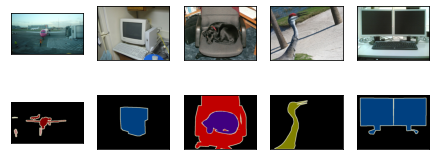

In [4]:
n = 5
imgs = train_features[0:n] + train_labels[0:n]
d2l.show_images(imgs, 2, n);

A seguir, listamos cada valor de cor RGB nos rótulos e as categoriaes que eles rl.


In [5]:
#@save
VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]

#@save
VOC_CLASSES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
               'diningtable', 'dog', 'horse', 'motorbike', 'person',
               'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']

Depois de definir as duasAfter defining the two constantes acima, podemos encontrar facilmente o índice de categoria para cada pixel nos rótulobove, we can easily find the category index for each pixel in the labels.


In [6]:
#@save
def build_colormap2label():
    """Build an RGB color to label mapping for segmentation."""
    colormap2label = np.zeros(256 ** 3)
    for i, colormap in enumerate(VOC_COLORMAP):
        colormap2label[(colormap[0]*256 + colormap[1])*256 + colormap[2]] = i
    return colormap2label

#@save
def voc_label_indices(colormap, colormap2label):
    """Map an RGB color to a label."""
    colormap = colormap.astype(np.int32)
    idx = ((colormap[:, :, 0] * 256 + colormap[:, :, 1]) * 256
           + colormap[:, :, 2])
    return colormap2label[idx]

PFor exeamploe, na primeira imagem dein the first exeamplo, o índice de categoria para a parte frontal do avião é 1 e o índice para o fundo ée image, the cat 0.


In [7]:
y = voc_label_indices(train_labels[0], build_colormap2label())
y[105:115, 130:140], VOC_CLASSES[1]

(array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.]]),
 'aeroplane')

### Pré-processamento de Dados

NosData Preprocessing

In the preceding chapítulos anteriores, dimensionamos asters, we scaled imagens para que se ajustassem à forma de entrada doto make them fit the inputmodelo. NaIn segmentação semântica, esse método exigiria que mapeamos novamente as categorias de pixels previstas de volta à imagem de entrada do tamanho original. Seria muito difícil fazer isso commantic segmentation, this method would require us to re-map the predicted pixel categories back to the original-size input image. It would be very difficult to do this precisãoely, especialmente em regiões segmentadas com semânticasly in segmented regions with differentes. Para evitar esse semantics. To avoid this problema, recortamos aswe crop the imagens para definir as dimensões e não as dimensionamos. Especificamente, usamos o método de corte aleatório usado no aumento da imagem para cortar a mesma região dasto set dimensions and do not scale them. Specifically, we use the random cropping method used in image augmentation to crop the same region from input imagens de entrada e seus rótuloand their labels.


In [8]:
#@save
def voc_rand_crop(feature, label, height, width):
    """Randomly crop for both feature and label images."""
    feature, rect = image.random_crop(feature, (width, height))
    label = image.fixed_crop(label, *rect)
    return feature, label

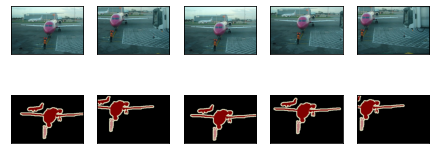

In [9]:
imgs = []
for _ in range(n):
    imgs += voc_rand_crop(train_features[0], train_labels[0], 200, 300)
d2l.show_images(imgs[::2] + imgs[1::2], 2, n);

###  *Datasets* para Segmentação Semântica Personalizada

Usamos a classe `Dataset` herdada fornecida pelo Gluon para personalizar a classe de conjunto de dados de segmentação semântica `VOCSegDataset`. IBy implementando a funçãoing the `__getitem__`, podemos acessar arbitrariamente a imagem de entrada com o índice `idx` e os índices de categoria para cada um de seus pixels do conjunto de dados. Como algumas function, we can arbitrarily access the input image with the index `idx` and the category indexes for each of its pixels from the dataset. As some imagens no conjunto de dados podem ser menores do que as dimensões de saída especificadas para corte aleatório, devemos remover essesin the dataset may be smaller than the output dimensions specified for random cropping, we must remove these exeamplos usando uma função `filter` personalizada. Além disso, definimos a função `normalize_image` para normalizar cada um dos três canais RGB das imagens de entradae by using a custom `filter` function. In addition, we define the `normalize_image` function to normalize each of the three RGB channels of the input images.


In [10]:
#@save
class VOCSegDataset(gluon.data.Dataset):
    """A customized dataset to load VOC dataset."""

    def __init__(self, is_train, crop_size, voc_dir):
        self.rgb_mean = np.array([0.485, 0.456, 0.406])
        self.rgb_std = np.array([0.229, 0.224, 0.225])
        self.crop_size = crop_size
        features, labels = read_voc_images(voc_dir, is_train=is_train)
        self.features = [self.normalize_image(feature)
                         for feature in self.filter(features)]
        self.labels = self.filter(labels)
        self.colormap2label = build_colormap2label()
        print('read ' + str(len(self.features)) + ' examples')

    def normalize_image(self, img):
        return (img.astype('float32') / 255 - self.rgb_mean) / self.rgb_std

    def filter(self, imgs):
        return [img for img in imgs if (
            img.shape[0] >= self.crop_size[0] and
            img.shape[1] >= self.crop_size[1])]

    def __getitem__(self, idx):
        feature, label = voc_rand_crop(self.features[idx], self.labels[idx],
                                       *self.crop_size)
        return (feature.transpose(2, 0, 1),
                voc_label_indices(label, self.colormap2label))

    def __len__(self):
        return len(self.features)

### Lendo oReading the Dataset

Usando a classeing the custom `VOCSegDataset` personalizada, criamos o conjunto dclass, we create the treainamento e as instâncias do conjunto de teste. Assumimos que a operação de corte aleatório produzing set and testing set instances. We assume the random cropping operation output imagens no formatoin the shape $320\times 480$. Abaixo, podemos ver o número deBelow, we can see the number of exeamploes retidos nos conjuntos dained in the treainamento e testeing and testing sets.


In [11]:
crop_size = (320, 480)
voc_train = VOCSegDataset(True, crop_size, voc_dir)
voc_test = VOCSegDataset(False, crop_size, voc_dir)

read 1114 examples


read 1078 examples


Definimos o tamanho do lote comWe set the batch size to 64 eand definimos ose the iteradtores para os conjuntos dfor the treainamento e teste. Imprimimos a forma do primeiroing and testing sets. Print the shape of the first minibatch. EmIn contraste com a to image classificação de imagens e o reconhecimento de objetos, os rótulos aqui são matrizes trition and object recognition, labels here are three-dimensionail arrays.


In [12]:
batch_size = 64
train_iter = gluon.data.DataLoader(voc_train, batch_size, shuffle=True,
                                   last_batch='discard',
                                   num_workers=d2l.get_dataloader_workers())
for X, Y in train_iter:
    print(X.shape)
    print(Y.shape)
    break

(64, 3, 320, 480)
(64, 320, 480)


### Juntando Tudo

Finalmente, definimos uma função `load_data_voc` que baixa e carrega este *Putting All Things Together

Finally, we define a function `load_data_voc` that  downloads and loads this dataset*, e entãoand then retourna oss the data iteradtores de dados.


In [13]:
#@save
def load_data_voc(batch_size, crop_size):
    """Download and load the VOC2012 semantic dataset."""
    voc_dir = d2l.download_extract('voc2012', os.path.join(
        'VOCdevkit', 'VOC2012'))
    num_workers = d2l.get_dataloader_workers()
    train_iter = gluon.data.DataLoader(
        VOCSegDataset(True, crop_size, voc_dir), batch_size,
        shuffle=True, last_batch='discard', num_workers=num_workers)
    test_iter = gluon.data.DataLoader(
        VOCSegDataset(False, crop_size, voc_dir), batch_size,
        last_batch='discard', num_workers=num_workers)
    return train_iter, test_iter

## Resumo

* A segmentação semântica analisa como asSummary

* Semantic segmentation looks at how imagens podem ser segmentadas em regiões comcan be segmented into regions with differentes categorias semânticas.
* No campo de segmentação semântica, um conjunto de dados importante é semantic categories.
* In the semantic segmentation field, one important dataset is Pascal VOC2012.
* Como asBecause the input imagens e rótulos de entrada na segmentação semântica têm umaand labels in semantic segmentation have a one-to-one correspondêencia um a um no nível do pixel, nós os cortamos aleatoriamente em um tamanho fixo, em vez de dimensioná-lose at the pixel level, we randomly crop them to a fixed size, rather than scaling them.

## Exercícioises

1. Lembre-se do conteúdo que vimos emRecall the content we covered in :numref:`sec_image_augmentation`. Qual dos métodos dWhich of the image augmento de imagem usados na classificação de imagens seria difícil de usar na segmentação semânticaation methods used in image classification would be hard to use in semantic segmentation?


[Discussõeions](https://discuss.d2l.ai/t/375)


<!--stackedit_data:
eyJoaXN0b3J5IjpbMjAzNTk5MTI4NCwyNzY0Mzk2MCwtMjAwNT
M0NzQzNiwtMTI5MDQ0NTY2OCwyOTQ1MTU5MTgsLTIwMTk1ODQx
NDddfQ==
-->
